<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_metaparameters_multioutput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

## Create and inspect data

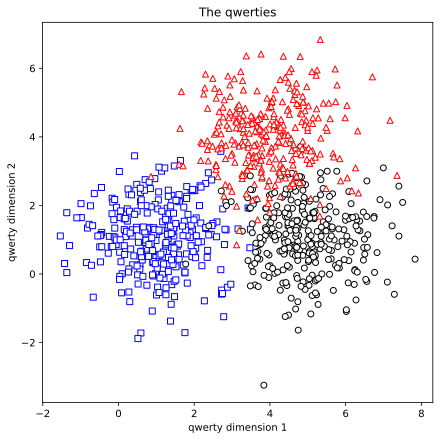

In [4]:
# create data
# create data 
nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 4]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1)), np.ones((nPerClust, 1))+1))
# concatenate into a matrix
data_np = np.hstack((a, b, c)).T
# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize=(7,7))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs', markerfacecolor='w')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko', markerfacecolor='w')
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels==2)[0], 1], 'r^', markerfacecolor='w')
plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# then convert into pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [6]:
# how many batches are there?
print(f'There are {len(train_loader)} batches, each with {batchsize} smaples.')

There are 45 batches, each with 16 smaples.


## Create and validate the model

In [7]:
# create a class for the model
def createTheQwertyNet():

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(2, 8)

            ## hidden layer
            self.fc1 = nn.Linear(8, 8)

            ## output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):

            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))

            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfun, optimizer

In [8]:
# test the model with fake input

net, lossf, opt = createTheQwertyNet()
print(net)

#input is ten samples
input = torch.randn(10, 2)
net(input)

qwertyNet(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[-0.0609,  0.1952, -0.2218],
        [-0.0647,  0.1773, -0.1886],
        [-0.0525,  0.1948, -0.2101],
        [-0.0836,  0.1623, -0.2022],
        [ 0.0521,  0.1759, -0.4252],
        [-0.0088,  0.2554, -0.2857],
        [-0.0654,  0.1825, -0.1942],
        [-0.0421,  0.2279, -0.2510],
        [ 0.0007,  0.2379, -0.2957],
        [-0.0296,  0.1399, -0.1837]], grad_fn=<AddmmBackward0>)

# A function that trains the model

In [21]:
def function2trainTheModel():
    numepochs = 100

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):
        
        #switch to training mode
        net.train()


        batchLoss = []
        batchAcc = []
        # loop over batches
        for X, y in train_loader:

            #forward pass
            yHat = net(X)
            loss = lossfun(yHat, y)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100 * torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        # end of batch loop

        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))
    # end epochs

    # function outputs
    return trainAcc, testAcc, losses, net

            


## Run the model and plot the results

In [22]:
# run the model
trainAcc, testAcc, losses, net = function2trainTheModel()

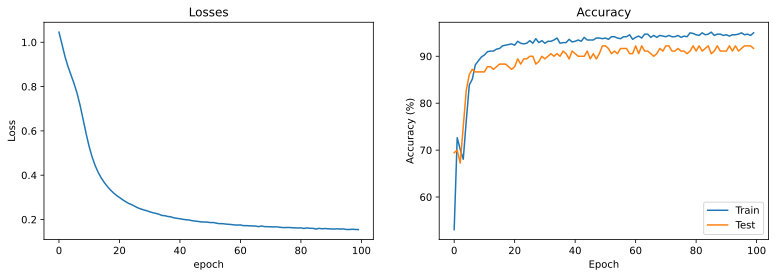

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

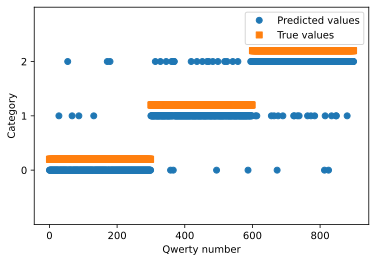

In [30]:
# run the data through the model to get the categorical predicitions
yHat = net(data)
predictions = torch.argmax(yHat, axis=1)

# and plot those against the real data
plt.plot(predictions, 'o', label='Predicted values')
plt.plot(labels + .2, 's', label='True values')
plt.xlabel('Qwerty number')
plt.ylabel('Category')
plt.yticks([0, 1, 2])
plt.ylim([-1, 3])
plt.legend()
plt.show()

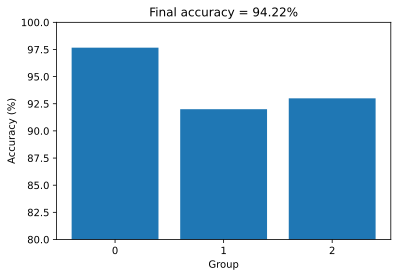

In [31]:
accuracy = (predictions == labels).float()

# compute overall accuracy
totalAcc = torch.mean(100 * accuracy).item()

# and average by group
accuracyByGroup = np.zeros(3)
for i in range(3):
    accuracyByGroup[i] = 100 * torch.mean(accuracy[labels==i])

plt.bar(range(3), accuracyByGroup)
plt.ylim([80, 100])
plt.xticks([0, 1, 2])
plt.xlabel('Group')
plt.ylabel('Accuracy (%)')
plt.title(f'Final accuracy = {totalAcc:.2f}%')
plt.show()

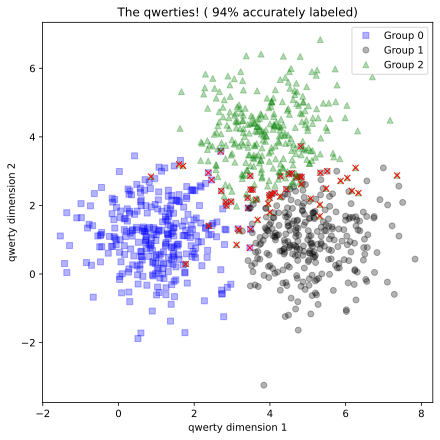

In [32]:
## Finally, show the qwerties in their native space, labeled by accuracy

# data merkers
colorShapes = ['bs', 'ko', 'g^']

# show the data
fig = plt.figure(figsize=(7, 7))

# plot correct and incorrect labeled data
for i in range(3):

    # plot all data points for this label
    plt.plot(data[labels==i, 0], data[labels==i, 1], colorShapes[i], alpha=.3, label=f'Group {i}')

    # cros out the incorrect ones
    idxErr = (accuracy == 0) & (labels == i)
    plt.plot(data[idxErr, 0], data[idxErr, 1], 'rx')

plt.title(f'The qwerties! ({totalAcc: .0f}% accurately labeled)')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()
